In [1]:
import os
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from collections import defaultdict
import copy # Needed for deep copying the logic

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("Please declare environment variable 'SUMO_HOME'")

import traci

# Parameters for the Q-learning agent
MAX_VEHICLES_PER_LANE = 20 # Define a max number of vehicles for state scaling
ALPHA = 0.1             # Learning rate
GAMMA = 0.95            # Discount factor
EPSILON = 1.0           # Initial exploration rate
EPSILON_MIN = 0.01      # Minimum exploration rate
EPSILON_DECAY = 0.995   # Decay rate for exploration
NUM_EPISODES = 100      # Number of episodes
STEPS_PER_EPISODE = 200 # Increased steps per episode for longer learning
MIN_GREEN_TIME = 5      # Minimum green time for safety/practicality
YELLOW_TIME = 3         # Standard yellow time

# Define the actions: Each action defines GREEN time durations for main phases
# We assume a standard 4-phase cycle: G1, Y1, G2, Y2
# Action defines the duration of G1 and G2. Yellow phases are fixed.
ACTIONS = {
    # Action: (Green time for C1 direction, Green time for C2 direction)
    0: {'name': 'Prioritize C1', 'green_times': [25, MIN_GREEN_TIME]}, # Longer green for C1
    1: {'name': 'Prioritize C2', 'green_times': [MIN_GREEN_TIME, 25]}, # Longer green for C2
    2: {'name': 'Balanced',      'green_times': [15, 15]},             # Equal priority
    # Add more actions if needed, e.g., shorter cycles
    3: {'name': 'Short Balanced','green_times': [10, 10]},
}
# Assuming a 4-phase structure like:
# Phase 0: Green for C1 (e.g., "GrGrrrrr") - Duration determined by action
# Phase 1: Yellow for C1 (e.g., "yryrrrrr") - Duration fixed (YELLOW_TIME)
# Phase 2: Green for C2 (e.g., "rrrGrGrr") - Duration determined by action
# Phase 3: Yellow for C2 (e.g., "rrryryrr") - Duration fixed (YELLOW_TIME)
PHASE_INDEX_GREEN_C1 = 0
PHASE_INDEX_YELLOW_C1 = 1
PHASE_INDEX_GREEN_C2 = 2
PHASE_INDEX_YELLOW_C2 = 3

class SUMOEnvironment:
    def __init__(self, sumo_cmd):
        self.sumo_cmd = sumo_cmd
        self.tl_id = "n2"  # Traffic light ID from your simulation
        # Define lanes for congestion measurement (use approach lanes *before* the intersection)
        self.lanes = {
            "C1": "e1_0",  # Lane approaching from West (adjust if needed)
            "C2": "e3_0"   # Lane approaching from North (adjust if needed)
        }
        self._current_logic = None # To store the base logic

    def start(self):
        """Start the SUMO simulation"""
        traci.start(self.sumo_cmd)
        # Store the initial program logic to modify later
        # Assuming only one program exists initially. If multiple, get the current one.
        all_logics = traci.trafficlight.getAllProgramLogics(self.tl_id)
        if not all_logics:
             raise ValueError(f"Traffic light '{self.tl_id}' has no programs defined in SUMO.")
        self._current_logic = copy.deepcopy(all_logics[0]) # Store a copy
        print(f"Initial logic for {self.tl_id} program '{self._current_logic.programID}':")
        for i, phase in enumerate(self._current_logic.phases):
            print(f"  Phase {i}: Duration={phase.duration}, State='{phase.state}'")
        # Verify phase indices match expectations
        if len(self._current_logic.phases) != 4:
            print(f"Warning: Expected 4 phases for TL '{self.tl_id}', but found {len(self._current_logic.phases)}. Action mapping might be incorrect.")


    def reset(self):
        """Reset the simulation and return the initial state"""
        if traci.isLoaded():
            traci.close()

        self.start() # Start simulation and load initial logic

        # Run a few steps to allow vehicles to appear
        for _ in range(5):
             traci.simulationStep()

        return self._get_state()

    def step(self, action):
        """Apply action, run simulation for one cycle, return new state, reward, done"""
        if self._current_logic is None:
            raise RuntimeError("Environment not started or logic not loaded.")

        # 1. Apply the selected action by changing traffic light phase durations
        cycle_duration = self._apply_action(action)

        # 2. Run simulation for the duration of the applied cycle
        accumulated_reward = 0
        steps_taken = 0
        for _ in range(cycle_duration):
            if traci.simulation.getMinExpectedNumber() <= 0:
                 # print("Simulation ended prematurely (no more vehicles).")
                 break # Stop if no vehicles left
            traci.simulationStep()
            steps_taken += 1
            # Accumulate reward over the cycle (optional, could also just use end-state)
            # Using halting vehicles as a penalty
            c1_halt = traci.lane.getLastStepHaltingNumber(self.lanes["C1"])
            c2_halt = traci.lane.getLastStepHaltingNumber(self.lanes["C2"])
            accumulated_reward -= (c1_halt + c2_halt) # Penalize waiting

        # 3. Get new state
        new_state = self._get_state()

        # 4. Calculate reward for the cycle (using accumulated penalty)
        reward = accumulated_reward / steps_taken if steps_taken > 0 else 0
        # Alternative reward: negative congestion at the *end* of the cycle
        # c1_end, c2_end = self._get_raw_congestion()
        # reward = -(c1_end + c2_end)

        # 5. Check if simulation is done (rely on step count in main loop)
        done = traci.simulation.getMinExpectedNumber() <= 0

        return new_state, reward, done, steps_taken # Return steps taken in this cycle

    def close(self):
        """Close the simulation"""
        if traci.isLoaded():
            traci.close()
        print("SUMO connection closed.")

    def _get_raw_congestion(self):
        """Get raw vehicle counts for monitored lanes"""
        try:
            # Using halting number might be a better indicator of congestion
            c1 = traci.lane.getLastStepHaltingNumber(self.lanes["C1"])
            c2 = traci.lane.getLastStepHaltingNumber(self.lanes["C2"])
            # Alternative: Vehicle number
            # c1 = traci.lane.getLastStepVehicleNumber(self.lanes["C1"])
            # c2 = traci.lane.getLastStepVehicleNumber(self.lanes["C2"])
            return c1, c2
        except traci.exceptions.TraCIException as e:
            print(f"TraCI Error getting congestion: {e}", file=sys.stderr)
            # Return high congestion on error to discourage states leading to this
            return MAX_VEHICLES_PER_LANE, MAX_VEHICLES_PER_LANE

    def _get_state(self):
        """Get the current state (scaled congestion levels)"""
        c1_raw, c2_raw = self._get_raw_congestion()

        # Scale congestion to a discrete range (0 to MAX_VEHICLES_PER_LANE)
        # Using ceil ensures that even 1 vehicle registers as state 1
        c1_scaled = min(int(np.ceil(c1_raw)), MAX_VEHICLES_PER_LANE)
        c2_scaled = min(int(np.ceil(c2_raw)), MAX_VEHICLES_PER_LANE)

        return (c1_scaled, c2_scaled)

    def _apply_action(self, action):
        """Apply the selected action by changing green phase durations in the program logic"""
        if action not in ACTIONS:
            print(f"Warning: Invalid action {action} received.")
            return YELLOW_TIME * 2 # Return a minimal duration if action is invalid

        green_times = ACTIONS[action]['green_times']
        g1_duration = max(MIN_GREEN_TIME, green_times[0]) # Ensure minimum green time
        g2_duration = max(MIN_GREEN_TIME, green_times[1]) # Ensure minimum green time

        # Create a mutable copy of the base logic for modification
        modified_logic = copy.deepcopy(self._current_logic)

        # --- IMPORTANT: Adjust phase indices based on your actual SUMO definition ---
        # Check the phase states printed during env.start() to confirm indices
        try:
            modified_logic.phases[PHASE_INDEX_GREEN_C1].duration = g1_duration
            modified_logic.phases[PHASE_INDEX_YELLOW_C1].duration = YELLOW_TIME
            modified_logic.phases[PHASE_INDEX_GREEN_C2].duration = g2_duration
            modified_logic.phases[PHASE_INDEX_YELLOW_C2].duration = YELLOW_TIME

            # Set the modified logic for the current program
            traci.trafficlight.setProgramLogic(self.tl_id, modified_logic)
            # print(f"Applied Action {action}: G1={g1_duration}s, G2={g2_duration}s")

            # Return the total duration of this new cycle
            total_cycle_duration = g1_duration + YELLOW_TIME + g2_duration + YELLOW_TIME
            return total_cycle_duration

        except IndexError:
             print(f"Error: Phase index out of bounds for TL '{self.tl_id}'. Check PHASE_INDEX constants and SUMO definition.", file=sys.stderr)
             # Return a default duration to avoid crashing, but this indicates a setup error
             return MIN_GREEN_TIME * 2 + YELLOW_TIME * 2
        except Exception as e:
            print(f"Error applying action {action}: {e}", file=sys.stderr)
            return MIN_GREEN_TIME * 2 + YELLOW_TIME * 2


def train_q_learning_agent(use_gui=False):
    """Train a Q-learning agent in the SUMO environment"""
    # Initialize Q-table: state -> action -> value
    # State is a tuple (c1_scaled, c2_scaled)
    q_table = defaultdict(lambda: np.zeros(len(ACTIONS)))

    # Command to start SUMO (use sumo for faster training, sumo-gui for visualization)
    sumo_binary = "sumo-gui" if use_gui else "sumo"
    # --- IMPORTANT: Ensure 'simulation.sumocfg' points to your config file ---
    config_path = "simulation.sumocfg"
    if not os.path.exists(config_path):
        sys.exit(f"Error: SUMO configuration file '{config_path}' not found.")
    sumo_cmd = [sumo_binary, "-c", config_path, "--quit-on-end"]
    # Optional: Add options like --step-length 0.5 for finer control if needed

    # Create environment
    env = SUMOEnvironment(sumo_cmd)

    # For plotting
    rewards_per_episode = []
    steps_per_episode_list = []
    epsilon = EPSILON

    print("Starting Q-Learning Training...")
    start_time = time.time()

    for episode in range(NUM_EPISODES):
        state = env.reset()
        total_reward = 0
        total_steps_in_episode = 0
        done = False

        while total_steps_in_episode < STEPS_PER_EPISODE:
            # Choose action based on epsilon-greedy policy
            if random.random() < epsilon:
                action = random.choice(list(ACTIONS.keys()))  # Exploration
            else:
                # Check if state exists, otherwise default to zeros (or explore)
                if state not in q_table:
                     action = random.choice(list(ACTIONS.keys())) # Explore if state is new
                else:
                     action = np.argmax(q_table[state])  # Exploitation

            # Take action and observe new state and reward
            # env.step now returns steps taken in that cycle
            next_state, reward, done, steps_this_cycle = env.step(action)
            total_reward += reward * steps_this_cycle # Weight reward by cycle duration
            total_steps_in_episode += steps_this_cycle

            # Update Q-value using Bellman equation
            # Ensure next_state exists in q_table for the update
            if next_state not in q_table:
                q_table[next_state] = np.zeros(len(ACTIONS))

            best_next_action_value = np.max(q_table[next_state])
            q_table[state][action] = q_table[state][action] + ALPHA * (
                reward + GAMMA * best_next_action_value - q_table[state][action]
            )

            # Move to next state
            state = next_state

            if done:
                # print(f"Episode {episode} finished early due to simulation end.")
                break # Exit inner loop if simulation finishes

        # Decay epsilon
        epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)

        # Record metrics
        rewards_per_episode.append(total_reward)
        steps_per_episode_list.append(total_steps_in_episode)

        # Print progress
        if (episode + 1) % 10 == 0 or episode == NUM_EPISODES - 1:
            avg_reward = np.mean(rewards_per_episode[-10:]) # Avg reward of last 10 episodes
            print(f"Episode {episode + 1}/{NUM_EPISODES} | Steps: {total_steps_in_episode} | Total Reward: {total_reward:.2f} | Avg Reward (last 10): {avg_reward:.2f} | Epsilon: {epsilon:.3f}")

    # Training finished
    end_time = time.time()
    print(f"\nTraining finished in {end_time - start_time:.2f} seconds.")

    # Close the environment
    env.close()

    # Plot rewards over episodes
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(rewards_per_episode)
    # Add a moving average for clarity
    moving_avg = np.convolve(rewards_per_episode, np.ones(10)/10, mode='valid')
    plt.plot(np.arange(len(moving_avg)) + 9, moving_avg, label='Moving Avg (10 episodes)')
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward per Episode")
    plt.title("Q-Learning Training Progress (Reward)")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(steps_per_episode_list)
    plt.xlabel("Episodes")
    plt.ylabel("Steps per Episode")
    plt.title("Simulation Steps per Episode")
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("training_progress.png")
    print("Saved training progress plot to 'training_progress.png'")
    if use_gui: # Only show plot if not running headless
        plt.show()

    # Save the Q-table (convert defaultdict to dict for saving)
    try:
        np.save("q_table.npy", dict(q_table))
        print("Saved Q-table to 'q_table.npy'")
    except Exception as e:
        print(f"Error saving Q-table: {e}")

    return q_table

def evaluate_agent(q_table_path="q_table.npy", num_episodes=3, max_steps=500, use_gui=False):
    """Evaluate a trained Q-learning agent"""
    print("\nStarting Evaluation...")
    # Load the Q-table
    try:
        q_table_loaded = np.load(q_table_path, allow_pickle=True).item()
        # Convert back to defaultdict for easier handling of unseen states
        q_table = defaultdict(lambda: np.zeros(len(ACTIONS)), q_table_loaded)
        print(f"Loaded Q-table from {q_table_path}")
    except FileNotFoundError:
        print(f"Error: Q-table file '{q_table_path}' not found. Cannot evaluate.")
        return
    except Exception as e:
        print(f"Error loading Q-table: {e}")
        return

    # Command to start SUMO with GUI for visualization
    sumo_binary = "sumo-gui" if use_gui else "sumo"
    config_path = "simulation.sumocfg"
    if not os.path.exists(config_path):
        sys.exit(f"Error: SUMO configuration file '{config_path}' not found.")
    sumo_cmd = [sumo_binary, "-c", config_path, "--quit-on-end"]

    env = SUMOEnvironment(sumo_cmd)

    total_rewards_eval = []

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        total_steps_in_episode = 0

        print(f"\n--- Starting Evaluation Episode {episode + 1} ---")
        time.sleep(2) # Give time to see the GUI start

        while total_steps_in_episode < max_steps:
            # Choose the best action based on Q-values (no exploration)
            if state not in q_table or np.sum(q_table[state]) == 0:
                # If state is unknown or all actions have value 0, choose a default (e.g., balanced)
                action = 2 # Default to 'Balanced' action
                action_type = "Default (Unknown State)"
            else:
                action = np.argmax(q_table[state])
                action_type = "Greedy"

            action_details = ACTIONS[action]
            print(f"Step Block ~{total_steps_in_episode}: State={state}, Action={action} ({action_details['name']}) [{action_type}]")

            # Take action
            next_state, reward, done, steps_this_cycle = env.step(action)
            weighted_reward = reward * steps_this_cycle
            total_reward += weighted_reward
            total_steps_in_episode += steps_this_cycle

            print(f"  -> Cycle Steps: {steps_this_cycle}, Cycle Reward: {reward:.2f}, Weighted Reward: {weighted_reward:.2f}, New State: {next_state}")

            state = next_state

            if done:
                print("Evaluation episode finished early (simulation ended).")
                break

            # Slow down for visualization during evaluation
            time.sleep(0.1) # Small delay to make GUI changes visible

        print(f"--- Evaluation Episode {episode + 1} Finished ---")
        print(f"Total Steps: {total_steps_in_episode}, Total Reward: {total_reward:.2f}")
        total_rewards_eval.append(total_reward)

    env.close()
    print("\nEvaluation Complete.")
    print(f"Average reward over {num_episodes} evaluation episodes: {np.mean(total_rewards_eval):.2f}")


Starting Q-Learning Training...
 Retrying in 1 seconds
Initial logic for n2 program '1':
  Phase 0: Duration=10.0, State='Gr'
  Phase 1: Duration=4.0, State='yr'
  Phase 2: Duration=10.0, State='rG'
  Phase 3: Duration=4.0, State='ry'
Step #227.00 (0ms ?*RT. ?UPS, TraCI: 0ms, vehicles TOT 24 ACT 2 BUF 0)                    
 Retrying in 1 seconds
Initial logic for n2 program '1':
  Phase 0: Duration=10.0, State='Gr'
  Phase 1: Duration=4.0, State='yr'
  Phase 2: Duration=10.0, State='rG'
  Phase 3: Duration=4.0, State='ry'
Step #237.00 (0ms ?*RT. ?UPS, TraCI: 0ms, vehicles TOT 24 ACT 1 BUF 0)                    
 Retrying in 1 seconds
Initial logic for n2 program '1':
  Phase 0: Duration=10.0, State='Gr'
  Phase 1: Duration=4.0, State='yr'
  Phase 2: Duration=10.0, State='rG'
  Phase 3: Duration=4.0, State='ry'
Step #211.00 (0ms ?*RT. ?UPS, TraCI: 0ms, vehicles TOT 23 ACT 4 BUF 0)                    
 Retrying in 1 seconds
Initial logic for n2 program '1':
  Phase 0: Duration=10.0, Sta

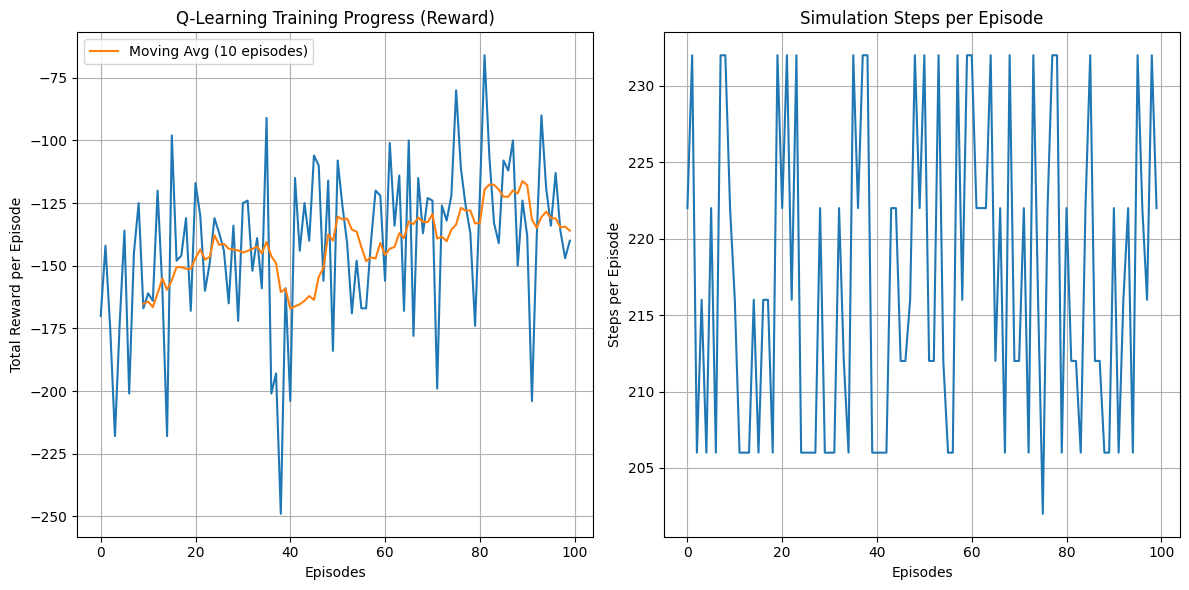

In [2]:
q_table = train_q_learning_agent()

In [3]:
evaluate_agent(q_table_path="q_table.npy", num_episodes=3, max_steps=500)


Starting Evaluation...
Loaded Q-table from q_table.npy
 Retrying in 1 seconds
Initial logic for n2 program '1':
  Phase 0: Duration=10.0, State='Gr'
  Phase 1: Duration=4.0, State='yr'
  Phase 2: Duration=10.0, State='rG'
  Phase 3: Duration=4.0, State='ry'

--- Starting Evaluation Episode 1 ---
Step Block ~0: State=(1, 0), Action=0 (Prioritize C1) [Greedy]
  -> Cycle Steps: 36, Cycle Reward: -0.83, Weighted Reward: -30.00, New State: (2, 0)
Step Block ~36: State=(2, 0), Action=2 (Balanced) [Greedy]
  -> Cycle Steps: 36, Cycle Reward: -0.58, Weighted Reward: -21.00, New State: (0, 0)
Step Block ~72: State=(0, 0), Action=3 (Short Balanced) [Greedy]
  -> Cycle Steps: 26, Cycle Reward: -0.12, Weighted Reward: -3.00, New State: (0, 0)
Step Block ~98: State=(0, 0), Action=3 (Short Balanced) [Greedy]
  -> Cycle Steps: 26, Cycle Reward: -0.27, Weighted Reward: -7.00, New State: (1, 0)
Step Block ~124: State=(1, 0), Action=0 (Prioritize C1) [Greedy]
  -> Cycle Steps: 36, Cycle Reward: -0.50, 